In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_pos_init_graph, plot_graph, get_neighbors_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, DigMontage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

train_A_chars = list(train_A_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')

A_train_ds = P300Getter(train_A_raw, eloc, sample_size=72)
A_test_ds = P300Getter(test_A_raw, eloc, sample_size=72, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

A_train_ds.upsample(4)
#A_test_ds.upsample(2)

X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.78it/s]


In [6]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 1024

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True)
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True)

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [10]:
positions = eloc.get_positions()['ch_pos']
points = np.stack(list(positions.values()))
ch_names = dict(enumerate(positions.keys()))

cuda:0
Training complete in 8m 56s
Accuracy:  0.6848333333333334
F1-score:  0.2528351648351648


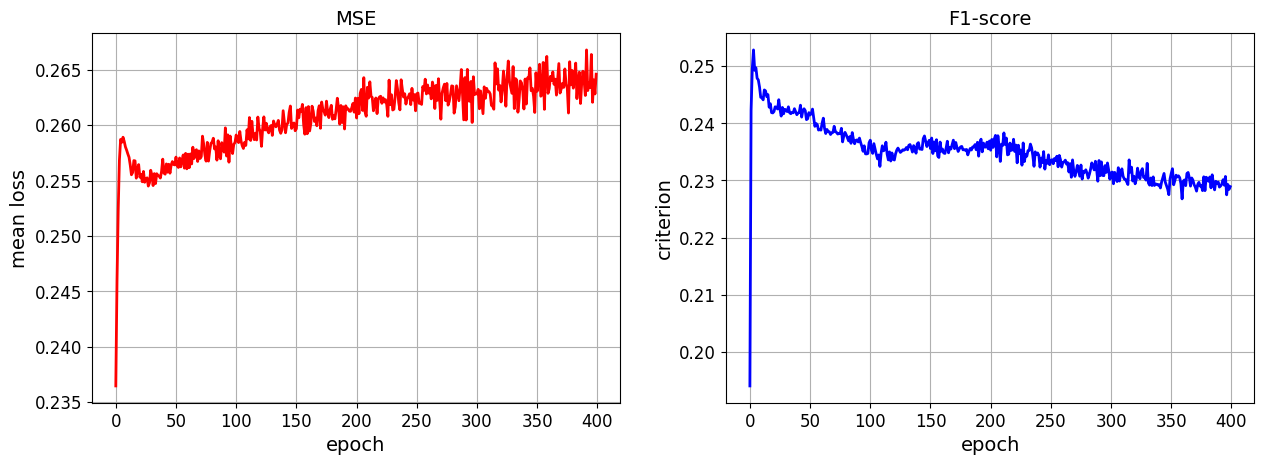

In [12]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Training complete in 8m 57s
Accuracy:  0.6867222222222222
F1-score:  0.2516952884191986


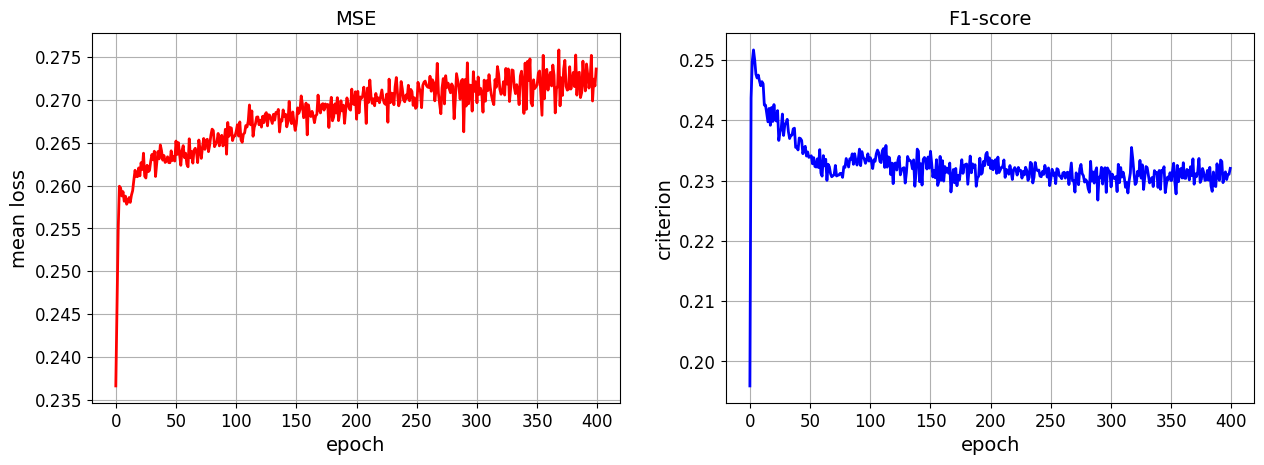

In [13]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = (get_pos_init_graph(eloc) * get_delaunay_graph(eloc)).toarray()
A = torch.tensor(A).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2472	 Min Acc: 0.5429	 Acc: 0.5490	 Max Acc: 0.5551	 Balanced Acc: 0.5490	 Positive: 440.7500	 Precision: 0.5591	 Recall: 0.4638	 F1-score: 0.5070	
val	 Loss: 0.2470	 Min Acc: 0.5707	 Acc: 0.5779	 Max Acc: 0.5851	 Balanced Acc: 0.5109	 Positive: 415.2941	 Precision: 0.1744	 Recall: 0.4103	 F1-score: 0.2447	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2372	 Min Acc: 0.5892	 Acc: 0.5953	 Max Acc: 0.6013	 Balanced Acc: 0.5953	 Positive: 516.9583	 Precision: 0.5979	 Recall: 0.5818	 F1-score: 0.5897	
val	 Loss: 0.2501	 Min Acc: 0.5475	 Acc: 0.5547	 Max Acc: 0.5620	 Balanced Acc: 0.5023	 Positive: 444.5294	 Precision: 0.1682	 Recall: 0.4237	 F1-score: 0.2408	
Epoch 29/399
-----

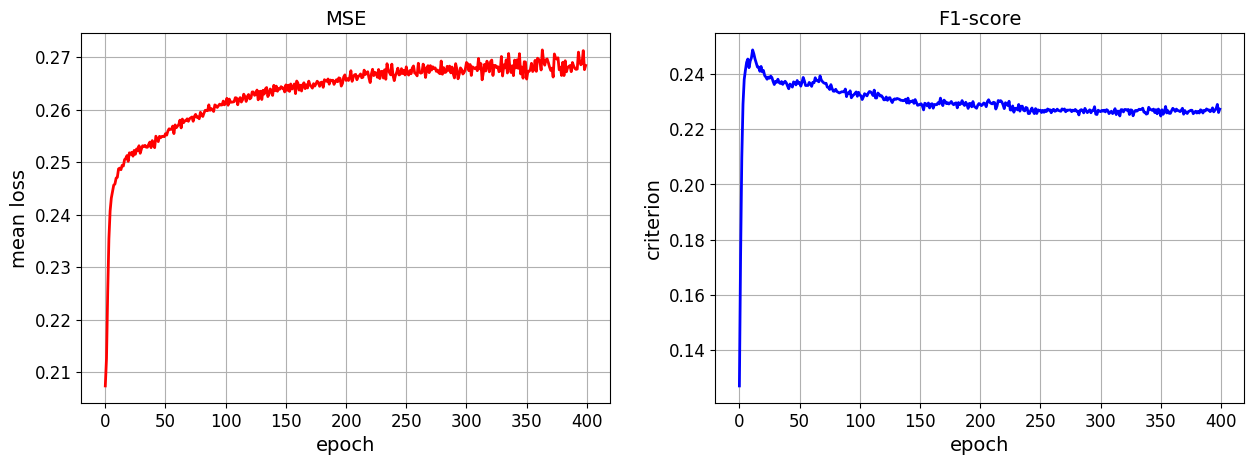

In [14]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2048	 Min Acc: 0.6734	 Acc: 0.6792	 Max Acc: 0.6849	 Balanced Acc: 0.6792	 Positive: 559.7083	 Precision: 0.6701	 Recall: 0.7060	 F1-score: 0.6875	
val	 Loss: 0.2562	 Min Acc: 0.5664	 Acc: 0.5736	 Max Acc: 0.5808	 Balanced Acc: 0.5066	 Positive: 418.2941	 Precision: 0.1713	 Recall: 0.4060	 F1-score: 0.2409	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.1805	 Min Acc: 0.7258	 Acc: 0.7313	 Max Acc: 0.7367	 Balanced Acc: 0.7313	 Positive: 559.4583	 Precision: 0.7196	 Recall: 0.7578	 F1-score: 0.7382	
val	 Loss: 0.2620	 Min Acc: 0.5840	 Acc: 0.5912	 Max Acc: 0.5983	 Balanced Acc: 0.5083	 Positive: 391.9412	 Precision: 0.1729	 Recall: 0.3840	 F1-score: 0.2384	
Epoch 29/399
-----

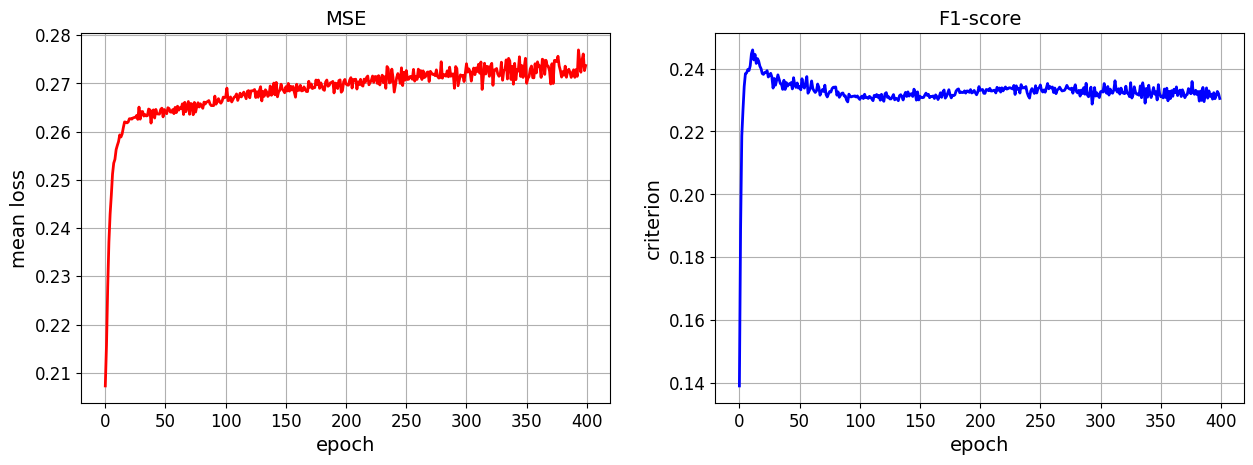

In [15]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.empty(64, 64)
k = math.sqrt(1 / (64 * 64))
nn.init.uniform_(A, -k, k)
A = A.to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2125	 Min Acc: 0.6554	 Acc: 0.6612	 Max Acc: 0.6670	 Balanced Acc: 0.6612	 Positive: 566.8333	 Precision: 0.6511	 Recall: 0.6947	 F1-score: 0.6722	
val	 Loss: 0.2606	 Min Acc: 0.5441	 Acc: 0.5513	 Max Acc: 0.5586	 Balanced Acc: 0.5029	 Positive: 450.4706	 Precision: 0.1686	 Recall: 0.4303	 F1-score: 0.2423	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.1921	 Min Acc: 0.6964	 Acc: 0.7020	 Max Acc: 0.7076	 Balanced Acc: 0.7020	 Positive: 561.5417	 Precision: 0.6911	 Recall: 0.7305	 F1-score: 0.7103	
val	 Loss: 0.2625	 Min Acc: 0.5690	 Acc: 0.5762	 Max Acc: 0.5834	 Balanced Acc: 0.5076	 Positive: 415.0588	 Precision: 0.1721	 Recall: 0.4047	 F1-score: 0.2414	
Epoch 29/399
-----

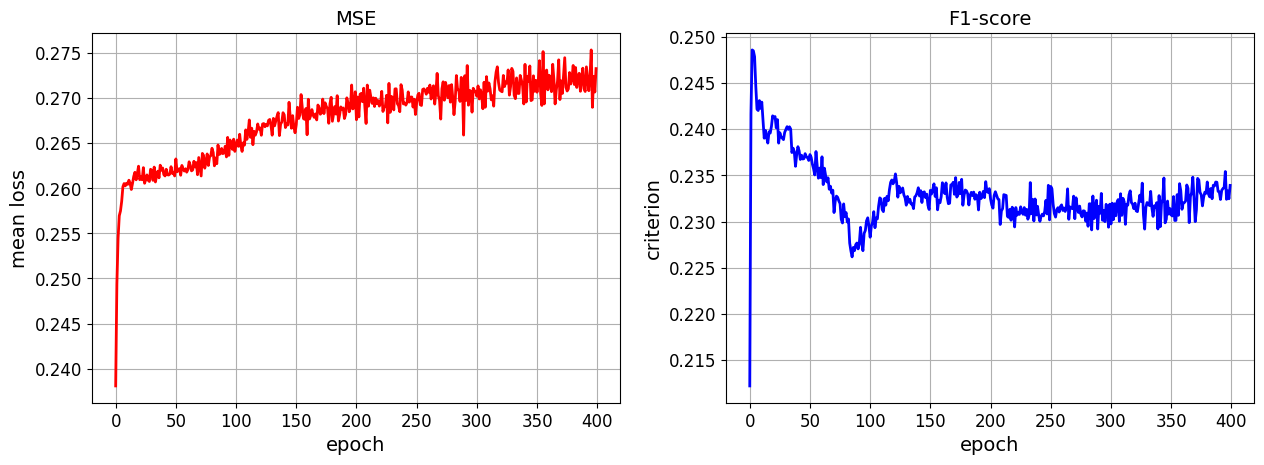

In [16]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = nn.Parameter(data=torch.eye(64, 64).to(my_device).float(), requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2358	 Min Acc: 0.5888	 Acc: 0.5948	 Max Acc: 0.6008	 Balanced Acc: 0.5948	 Positive: 538.0833	 Precision: 0.5936	 Recall: 0.6013	 F1-score: 0.5974	
val	 Loss: 0.2547	 Min Acc: 0.5323	 Acc: 0.5396	 Max Acc: 0.5469	 Balanced Acc: 0.4984	 Positive: 465.1176	 Precision: 0.1657	 Recall: 0.4367	 F1-score: 0.2402	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2228	 Min Acc: 0.6290	 Acc: 0.6349	 Max Acc: 0.6408	 Balanced Acc: 0.6349	 Positive: 542.0833	 Precision: 0.6322	 Recall: 0.6451	 F1-score: 0.6386	
val	 Loss: 0.2577	 Min Acc: 0.5479	 Acc: 0.5551	 Max Acc: 0.5624	 Balanced Acc: 0.5028	 Positive: 444.3529	 Precision: 0.1685	 Recall: 0.4243	 F1-score: 0.2412	
Epoch 29/399
-----

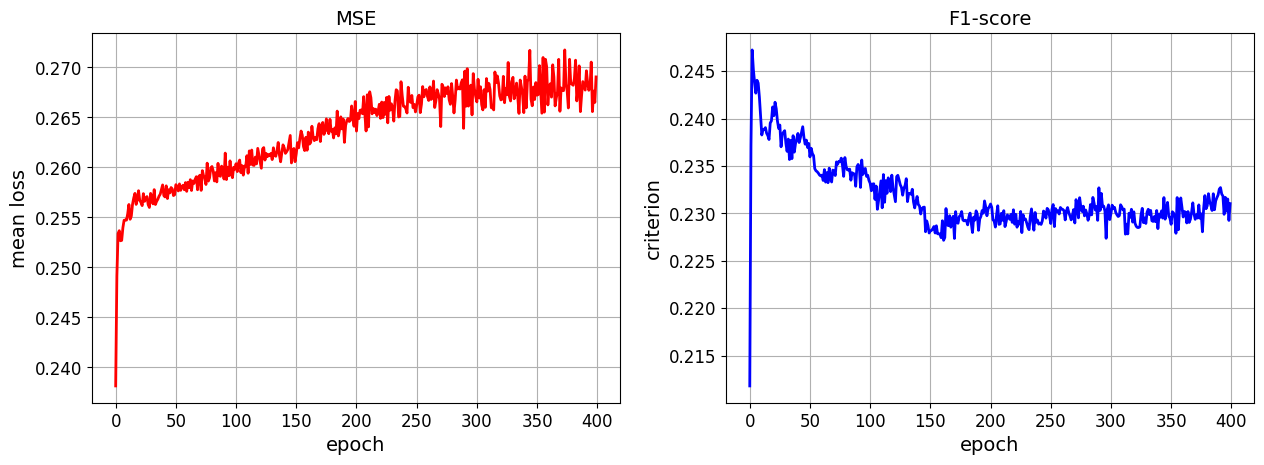

In [17]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.eye(64, 64).to(my_device).float()
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2158	 Min Acc: 0.6489	 Acc: 0.6547	 Max Acc: 0.6605	 Balanced Acc: 0.6547	 Positive: 558.0417	 Precision: 0.6473	 Recall: 0.6799	 F1-score: 0.6632	
val	 Loss: 0.2593	 Min Acc: 0.5479	 Acc: 0.5551	 Max Acc: 0.5624	 Balanced Acc: 0.5013	 Positive: 443.0588	 Precision: 0.1676	 Recall: 0.4207	 F1-score: 0.2397	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.1962	 Min Acc: 0.6899	 Acc: 0.6956	 Max Acc: 0.7012	 Balanced Acc: 0.6956	 Positive: 553.7083	 Precision: 0.6876	 Recall: 0.7167	 F1-score: 0.7019	
val	 Loss: 0.2611	 Min Acc: 0.5716	 Acc: 0.5788	 Max Acc: 0.5860	 Balanced Acc: 0.5074	 Positive: 410.7647	 Precision: 0.1720	 Recall: 0.4003	 F1-score: 0.2406	
Epoch 29/399
-----

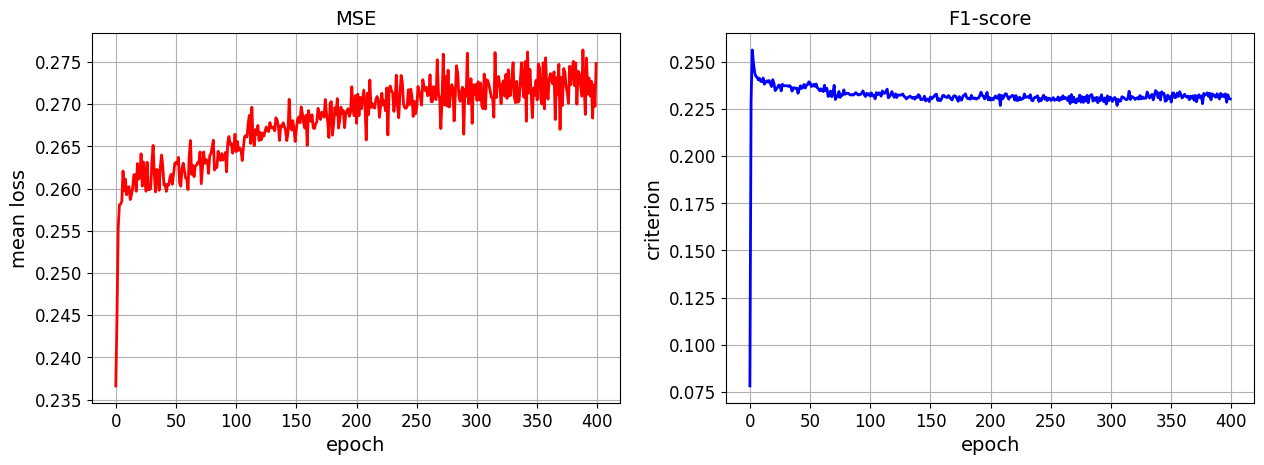

In [35]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2304	 Min Acc: 0.6097	 Acc: 0.6157	 Max Acc: 0.6217	 Balanced Acc: 0.6157	 Positive: 539.1667	 Precision: 0.6140	 Recall: 0.6231	 F1-score: 0.6185	
val	 Loss: 0.2582	 Min Acc: 0.5356	 Acc: 0.5428	 Max Acc: 0.5501	 Balanced Acc: 0.4960	 Positive: 457.8235	 Precision: 0.1641	 Recall: 0.4257	 F1-score: 0.2369	
Epoch 19/399
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2250	 Min Acc: 0.6307	 Acc: 0.6366	 Max Acc: 0.6425	 Balanced Acc: 0.6366	 Positive: 534.7083	 Precision: 0.6357	 Recall: 0.6398	 F1-score: 0.6378	
val	 Loss: 0.2587	 Min Acc: 0.5426	 Acc: 0.5499	 Max Acc: 0.5572	 Balanced Acc: 0.4938	 Positive: 444.7059	 Precision: 0.1626	 Recall: 0.4097	 F1-score: 0.2328	
Epoch 29/399
-----

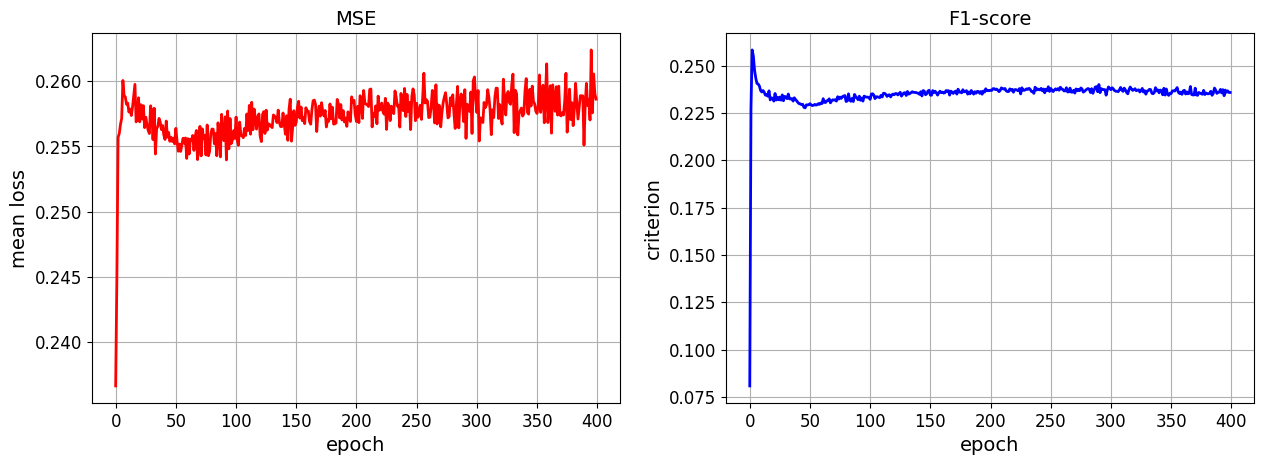

In [36]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 400,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')
print(my_device)

A = torch.tensor(get_pos_init_graph(eloc)).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Epoch 9/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.2050	 Min Acc: 0.6741	 Acc: 0.6798	 Max Acc: 0.6856	 Balanced Acc: 0.6798	 Positive: 570.5000	 Precision: 0.6675	 Recall: 0.7168	 F1-score: 0.6912	
val	 Loss: 0.2581	 Min Acc: 0.5586	 Acc: 0.5659	 Max Acc: 0.5731	 Balanced Acc: 0.5094	 Positive: 433.0588	 Precision: 0.1731	 Recall: 0.4247	 F1-score: 0.2459	
Epoch 19/99
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.1868	 Min Acc: 0.7131	 Acc: 0.7186	 Max Acc: 0.7241	 Balanced Acc: 0.7186	 Positive: 562.2083	 Precision: 0.7066	 Recall: 0.7478	 F1-score: 0.7266	
val	 Loss: 0.2628	 Min Acc: 0.5762	 Acc: 0.5834	 Max Acc: 0.5906	 Balanced Acc: 0.5082	 Positive: 404.1176	 Precision: 0.1726	 Recall: 0.3953	 F1-score: 0.2403	
Epoch 29/99
--------

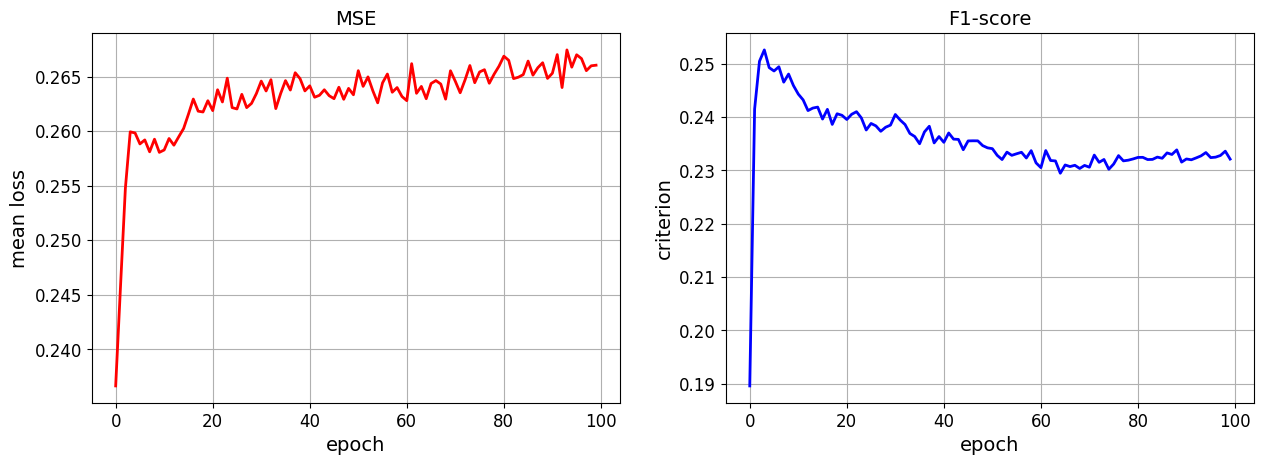

In [37]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device, log_rate=10)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Training complete in 4m 20s
Accuracy:  0.6857222222222222
F1-score:  0.25254042590792614


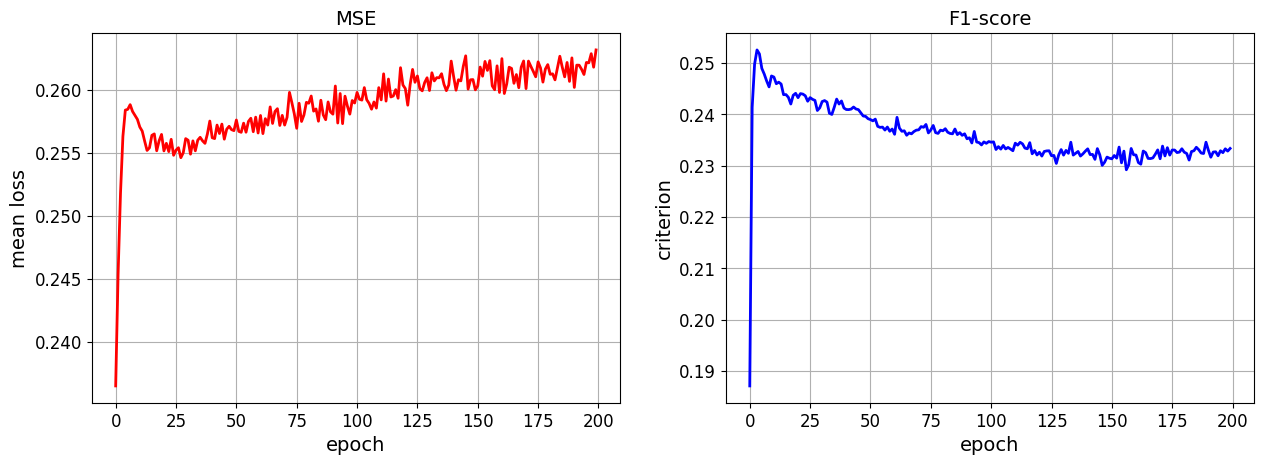

In [7]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 200,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Training complete in 4m 21s
Accuracy:  0.6970000000000001
F1-score:  0.25068167824786697


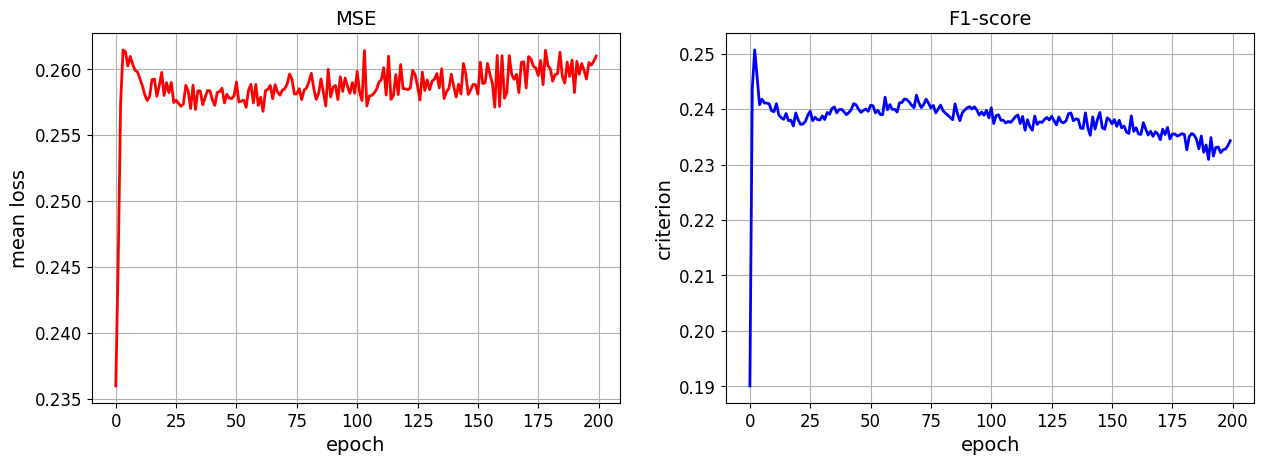

In [10]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 200,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_neighbors_graph(eloc).toarray()).to(my_device).float()
#A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')

cuda:0
Training complete in 4m 24s
Accuracy:  0.6987777777777778
F1-score:  0.2471395881006865


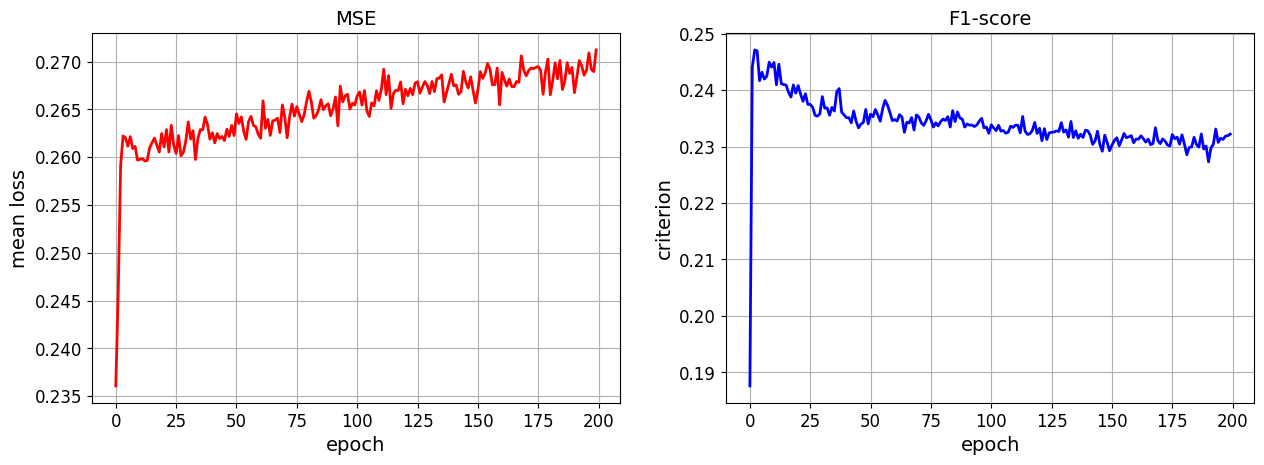

In [11]:
criterion = nn.MSELoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 200,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_neighbors_graph(eloc).toarray()).to(my_device).float()
A = nn.Parameter(data=A, requires_grad=True)
model_GNN = BaseGNN(48, 64, A)

loss, acc, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, device=my_device)
print('Accuracy: ', acc['Accuracy'].max())
print('F1-score: ', acc['F1-score'].max())
show_progress(loss, acc, 'MSE', 'F1-score')